# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install autots

In [3]:
# for data acquisition
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# for data handling
import pandas as pd

# for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# for time-series analysis
from autots import AutoTS, load_daily

# misc
import time

# Data Acquisition

## Sample Data

In [4]:
# check sample data
df_2010Q1 = pd.read_csv("/content/drive/MyDrive/iodata/2010Q1.csv")
df_2010Q1.head(3)

,Date,Category1,Category2,Category3,Maker,Sales,Identifier
0,2010-02-15,Air,Conditioners,NaN,Toshino,2143.0,RVFWTWSMNU
1,2010-02-15,Water,Heaters,NaN,Furutani,567.0,PF4KB33DVZ
2,2010-02-15,Washers,&,Dryers,Akaza,3515.0,VUQUQMHODG


## Bulk Data Acquisition

In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
file_list = drive.ListFile({'q': "title contains '.csv' and '1SEOZ81L7voOdRD-Np_VqYISAxQ7jIyPj' in parents"}).GetList()
list_id = []
list_title = []

for file in file_list:
    list_id.append(file['id'])
    list_title.append(file['title'])

In [7]:
# check the number of read files
len(list_id)

46

In [8]:
# combine all csv files into a dataframe
df = pd.DataFrame()

for id, title in zip(list_id, list_title):
    each_file = drive.CreateFile({'id': id})
    each_file.GetContentFile(title)
    df_each_file = pd.read_csv(title, skiprows=1, \
                               names=['Date', 'Category1', 'Category2', 'Category3', \
                                      'Maker', 'Sales', 'Identifier'])
    df = pd.concat([df, df_each_file], ignore_index=True)

In [9]:
# check top data
df.head()

,Date,Category1,Category2,Category3,Maker,Sales,Identifier
0,2013-07-01,Water,Pumps,NaN,Furutani,16878.0,FVDHIZGQRC
1,2013-07-01,Televisions,NaN,NaN,Okamoto,1384.0,HANYALJGGA
2,2013-07-01,Dishwashers,NaN,NaN,Nanase,1953.0,AVXSMNNRDX
3,2013-07-01,Refrigerators,NaN,NaN,Nanase,649.0,GQUIAFQIRH
4,2013-07-01,Washers,&,Dryers,Kikuma,2277.0,QFY2WV5LUE


In [56]:
# check data shape
df.shape

(93171, 5)

In [10]:
# check columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134964 entries, 0 to 134963
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Date        134964 non-null  object 
 1   Category1   134964 non-null  object 
 2   Category2   93196 non-null   object 
 3   Category3   30603 non-null   object 
 4   Maker       134964 non-null  object 
 5   Sales       129588 non-null  float64
 6   Identifier  134964 non-null  object 
dtypes: float64(1), object(6)
memory usage: 7.2+ MB


In [11]:
# check statistics
df.describe(include=[object])

,Date,Category1,Category2,Category3,Maker,Identifier
count,134964,134964,93196,30603,134964,134964
unique,2784,9,6,2,16,52
top,2020-08-06,Water,&,Cooktops,Akaza,TLSY3MWMK8
freq,52,20859,30603,16693,16694,2783


## Data Cleaning

In [12]:
# change data type of the column Date into 'Datetime'
# df['Sales'] = df['Sales'].astype(float)
df['Date']= pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134964 entries, 0 to 134963
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Date        134964 non-null  datetime64[ns]
 1   Category1   134964 non-null  object        
 2   Category2   93196 non-null   object        
 3   Category3   30603 non-null   object        
 4   Maker       134964 non-null  object        
 5   Sales       129588 non-null  float64       
 6   Identifier  134964 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 7.2+ MB


In [13]:
# combine the cateogies' columns into a new column called "Category"
df["Category"] = df[['Category1', 'Category2', 'Category3']].apply(lambda x: ' '.join(x.dropna()), axis=1)
df.head()

,Date,Category1,Category2,Category3,Maker,Sales,Identifier,Category
0,2013-07-01,Water,Pumps,NaN,Furutani,16878.0,FVDHIZGQRC,Water Pumps
1,2013-07-01,Televisions,NaN,NaN,Okamoto,1384.0,HANYALJGGA,Televisions
2,2013-07-01,Dishwashers,NaN,NaN,Nanase,1953.0,AVXSMNNRDX,Dishwashers
3,2013-07-01,Refrigerators,NaN,NaN,Nanase,649.0,GQUIAFQIRH,Refrigerators
4,2013-07-01,Washers,&,Dryers,Kikuma,2277.0,QFY2WV5LUE,Washers & Dryers


In [14]:
# now we can delete the columns Category1 to Category 3 that are no longer useful
df.drop(columns=['Category1', 'Category2', 'Category3'], inplace=True)
df.head(3)

,Date,Maker,Sales,Identifier,Category
0,2013-07-01,Furutani,16878.0,FVDHIZGQRC,Water Pumps
1,2013-07-01,Okamoto,1384.0,HANYALJGGA,Televisions
2,2013-07-01,Nanase,1953.0,AVXSMNNRDX,Dishwashers


## Exploratory Data Analysis (EDA)

In [60]:
# check the span of the dates
print("The dates' range is", df["Date"].max() - df["Date"].min())

The dates' range is 4091 days 00:00:00


In [15]:
# check data statistics
df.describe(include='all')

<ipython-input-15-c62a3103c285>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,Date,Maker,Sales,Identifier,Category
count,134964,134964,129588.000000,134964,134964
unique,2784,16,NaN,52,10
top,2020-08-06 00:00:00,Akaza,NaN,TLSY3MWMK8,Refrigerators
freq,52,16694,NaN,2783,19476
first,2010-02-15 00:00:00,NaN,NaN,NaN,NaN
last,2021-04-29 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,3486.478817,NaN,NaN
std,NaN,NaN,5432.144365,NaN,NaN
min,NaN,NaN,47.000000,NaN,NaN
25%,NaN,NaN,734.000000,NaN,NaN


In [51]:
# check nulls in the Sales column
df["Sales"].isnull().sum()

0

In [52]:
# assuming nulls mean no sales, fill nulls with zeroes
df["Sales"] = df["Sales"].fillna(0)
df["Sales"].isnull().sum()

0

In [53]:
# pivot data by product to see sales per category
cat_sales = df.pivot_table(values="Sales", index="Date",columns="Category")
cat_sales.head()

Category,Air Conditioners,Dishwashers,Ovens & Cooktops,Refrigerators,Rice Cookers,Televisions,Vacuum Cleaners,Washers & Dryers,Water Heaters,Water Pumps
Date,,,,,,,,,,
2010-02-15,1551.000000,2500.5,1778.6,1596.75,1630.25,178.000000,396.25,1975.0,314.0,10434.0
2010-02-16,1573.666667,2616.0,8027.4,1632.50,1672.75,168.666667,395.75,1996.0,0.0,10725.5
2010-02-17,841.000000,2660.0,8131.2,1666.50,1694.00,168.666667,399.25,2029.0,296.0,10914.5
2010-02-18,1591.333333,2600.5,7928.8,1664.00,1676.75,175.333333,395.75,2008.0,304.0,10705.5
2010-02-19,1585.333333,2574.0,7793.6,1669.25,1702.50,169.000000,312.50,2009.5,296.0,10616.0


In [54]:
# pivot data by product to see sales per category
cat_sales = df.pivot_table(values="Sales", index="Date",columns="Category")
cat_sales.head()

Category,Air Conditioners,Dishwashers,Ovens & Cooktops,Refrigerators,Rice Cookers,Televisions,Vacuum Cleaners,Washers & Dryers,Water Heaters,Water Pumps
Date,,,,,,,,,,
2010-02-15,1551.000000,2500.5,1778.6,1596.75,1630.25,178.000000,396.25,1975.0,314.0,10434.0
2010-02-16,1573.666667,2616.0,8027.4,1632.50,1672.75,168.666667,395.75,1996.0,0.0,10725.5
2010-02-17,841.000000,2660.0,8131.2,1666.50,1694.00,168.666667,399.25,2029.0,296.0,10914.5
2010-02-18,1591.333333,2600.5,7928.8,1664.00,1676.75,175.333333,395.75,2008.0,304.0,10705.5
2010-02-19,1585.333333,2574.0,7793.6,1669.25,1702.50,169.000000,312.50,2009.5,296.0,10616.0


<Axes: xlabel='Date'>

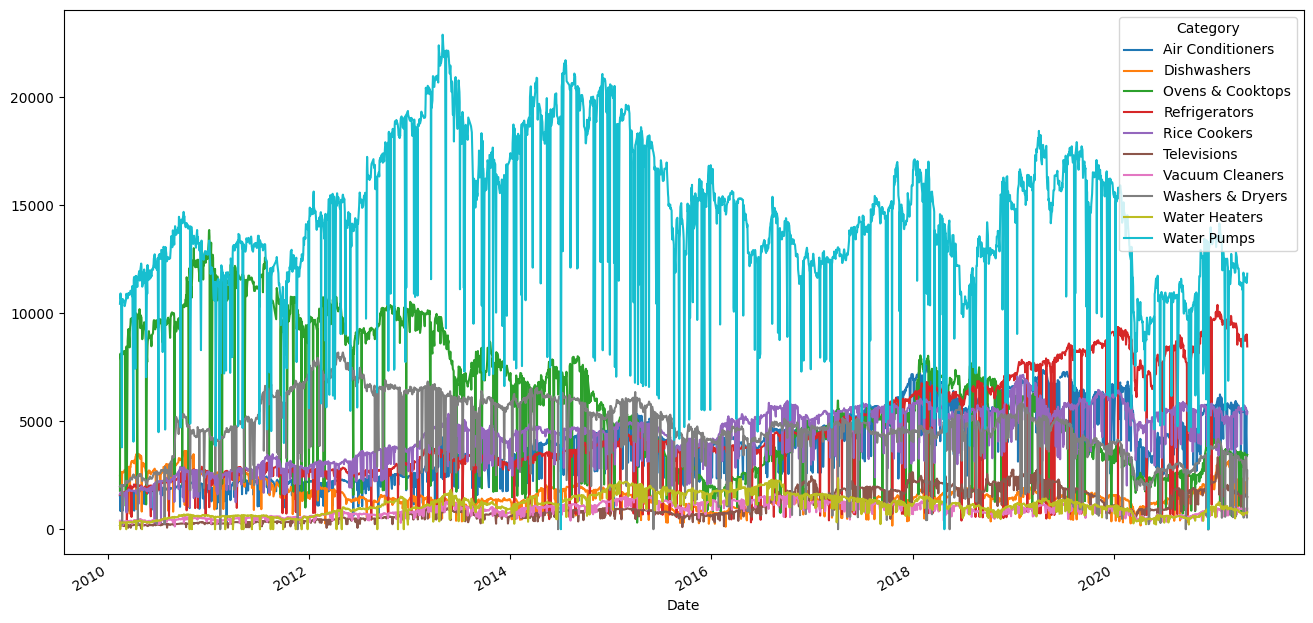

In [55]:
cat_sales.plot(figsize=(16,8))

# 1. Data Description

* Data source: data was given by the client.
* Data shape: the original data has 7 columns and 134964 rows
* Data types:
 - Date: object
 - Category1: object
 - Category2: object
 - Category3: object
 - Maker: object
 - Sales: float64
 - Identifier: object
* Missing values
 - Some values were missing from the Category1, 2, and 3 columns because the category for the respective product contains less than 3 words
 - Some values were missing from the Sales column presumably because there was no Sales on that day (zero)
* Time frame: the dates range from February 15, 2010 to April 29, 2021, or 4091 days.



 # 2. Take Out Data Belonging to PT. D.K. Works

The data is actually mixed with the data belonging to their sister company, PT. D.K. Works, before their split last year. These foreign data are easily identifiable, as they can be recognized by products having one or more digits in their identifier code. The identifier code is a string of 10 characters that consist of only letters in the data belonging to the client.
For example, a product with an identifier of “CTCNSTZEDP” belongs to PT. Denki Kobo (the client), while a product with an identifier of “PRN3TK7HWK” belongs to PT. D.K. Works (the sister company). Notice that the data belonging to PT D.K. Works has the number 3 and 7 in the identifier code.
Since the client and PT. D.K. Works had already parted ways, the latter’s data be taken out.

In [16]:
# count the number of DK Works data
df["Identifier"].str.contains('.*[0-9].*', regex=True).sum()

41793

In [17]:
# count DK Works data
[df["Identifier"].str.contains('.*[0-9].*', regex=True)]

[0         False
 1         False
 2         False
 3         False
 4          True
           ...  
 134959    False
 134960    False
 134961     True
 134962    False
 134963    False
 Name: Identifier, Length: 134964, dtype: bool]

In [18]:
# ensure the data selected are indeed DK Works data (Identifier contains numbers)
df.iloc[[4,134961],:]

,Date,Maker,Sales,Identifier,Category
4,2013-07-01,Kikuma,2277.0,QFY2WV5LUE,Washers & Dryers
134961,2013-03-28,Sugiura,1146.0,KR2Q6QT8PE,Dishwashers


In [19]:
# check initial number of rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134964 entries, 0 to 134963
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Date        134964 non-null  datetime64[ns]
 1   Maker       134964 non-null  object        
 2   Sales       129588 non-null  float64       
 3   Identifier  134964 non-null  object        
 4   Category    134964 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 5.1+ MB


In [20]:
# delete DK Works data and check final number of rows
df = df.drop(df[df["Identifier"].str.contains('.*[0-9].*', regex=True)].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93171 entries, 0 to 134963
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        93171 non-null  datetime64[ns]
 1   Maker       93171 non-null  object        
 2   Sales       89498 non-null  float64       
 3   Identifier  93171 non-null  object        
 4   Category    93171 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 4.3+ MB


In [21]:
# ensure no DK works data left
df["Identifier"].str.contains('.*[0-9].*', regex=True).sum()

0

# 3. Predict Future Sales Numbers

In [22]:
# order data based on date of sales then product maker
df.sort_values(["Date", "Maker"], ignore_index=True, inplace=True)
df.head()

,Date,Maker,Sales,Identifier,Category
0,2010-02-15,Akaza,3515.0,VUQUQMHODG,Washers & Dryers
1,2010-02-15,Akaza,687.0,XVIOZZOUTN,Refrigerators
2,2010-02-15,Akaza,342.0,ZBYVQNRPUP,Vacuum Cleaners
3,2010-02-15,Funami,726.0,BIBIOOIHA,Refrigerators
4,2010-02-15,Funami,360.0,VEWPPXWTWS,Vacuum Cleaners


## Daily Sales Prediction

In [23]:
# check min and max date
df["Date"].describe()

<ipython-input-23-9210e3241156>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df["Date"].describe()


count                   93171
unique                   2784
top       2021-04-29 00:00:00
freq                       36
first     2010-02-15 00:00:00
last      2021-04-29 00:00:00
Name: Date, dtype: object

In [24]:
# get daily sales data
daily = df.groupby('Date').sum()
daily.tail(3)

<ipython-input-24-ca2835b9c04e>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily = df.groupby('Date').sum()


,Sales
Date,
2021-04-27,139043.0
2021-04-28,134817.0
2021-04-29,139351.0


In [41]:
daily['Sales'].isna().sum()

0

In [ ]:
# if necessary, fill nulls with zeroe s
# daily['Sales'] = daily['Sales'].fillna(0)

In [25]:
# ensure data types are correct
daily.reset_index(inplace=True)
daily['Date']= pd.to_datetime(daily['Date'])
daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2784 entries, 0 to 2783
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2784 non-null   datetime64[ns]
 1   Sales   2784 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 43.6 KB


<Axes: xlabel='Date'>

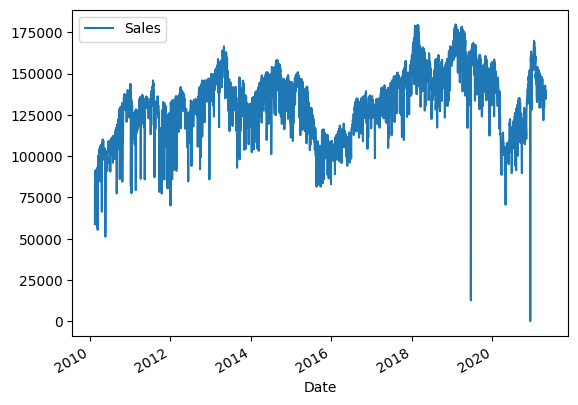

In [26]:
# visualize sales data
daily.plot.line("Date", "Sales")

In [27]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# annual['Sales'] = scaler.fit_transform(annual[['Sales']])
# annual.head()

In [28]:
# check model types available from autots
from autots.models.model_list import model_lists
print(model_lists.keys())

dict_keys(['all', 'default', 'fast', 'superfast', 'parallel', 'fast_parallel', 'fast_parallel_no_arima', 'scalable', 'probabilistic', 'multivariate', 'univariate', 'no_params', 'recombination_approved', 'no_shared', 'no_shared_fast', 'experimental', 'slow', 'gpu', 'regressor', 'best', 'motifs', 'all_result_path', 'regressions', 'all_pragmatic', 'update_fit'])


In [29]:
# check models available for univariate time series forecasting
print(model_lists['univariate'])

['ETS', 'ARDL', 'ConstantNaive', 'UnivariateMotif', 'LastValueNaive', 'SeasonalNaive', 'MetricMotif', 'AverageValueNaive', 'UnobservedComponents', 'Theta', 'FBProphet', 'ARIMA', 'NeuralProphet', 'SeasonalityMotif', 'FFT', 'ARCH', 'UnivariateRegression', 'GLS', 'DatepartRegression', 'MLEnsemble', 'PreprocessingRegression', 'GLM', 'KalmanStateSpace']


In [30]:
# build the model using three univariate models
models = ['ARIMA', 'FBProphet']

model = AutoTS(
    forecast_length=240,
    frequency='B',
    prediction_interval=0.9,
    ensemble=None,
    model_list = models, # or 'univariate' to use more models
    max_generations=5,
    num_validations=2,
    no_negatives=True,
    n_jobs='auto')

Using 1 cpus for n_jobs.


In [31]:
# record start time
start = time.time()

# fit model to data
model = model.fit(daily, date_col='Date', value_col='Sales')

# record end time
end = time.time()

# print the difference between start and end time in s
print("The training time is :", (end-start), "s.")

Data frequency is: B, used frequency is: B
Model Number: 1 with model ARIMA in generation 0 of 5
Model Number: 2 with model FBProphet in generation 0 of 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmp86qquh4j/ckiwfad_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86qquh4j/31pb67s6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51588', 'data', 'file=/tmp/tmp86qquh4j/ckiwfad_.json', 'init=/tmp/tmp86qquh4j/31pb67s6.json', 'output', 'file=/tmp/tmp86qquh4j/prophet_models1iq3ka5/prophet_model-20240126081634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:16:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:16:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 3 with model FBProphet in generation 0 of 5
Model Number: 4 with model ARIMA in generation 0 of 5
Model Number: 5 with model FBProphet in generation 0 of 5
Model Number: 6 with model FBProphet in generation 0 of 5
Model Number: 7 with model ARIMA in generation 0 of 5
Model Number: 8 with model FBProphet in generation 0 of 5
Model Number: 9 with model FBProphet in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 9 in generation 0: FBProphet
Model Number: 10 with model FBProphet in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 10 in generation 0: FBProphet
Model Number: 11 with model ARIMA in generation 0 of 5
Model Number: 12 with model FBProphet in generation 0 of 5
Model Number: 13 with model FBProphet in generation 0 of 5
New Generation: 1 of 5
Model Number: 14 with model FBProphet in generation 1 of 5
Model Number: 15 with model ARIMA

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 35 with model FBProphet in generation 3 of 5
Model Number: 36 with model ARIMA in generation 3 of 5
Model Number: 37 with model ARIMA in generation 3 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 37 in generation 3: ARIMA
Model Number: 38 with model FBProphet in generation 3 of 5
Model Number: 39 with model FBProphet in generation 3 of 5
No anomalies detected.
Model Number: 40 with model FBProphet in generation 3 of 5
Model Number: 41 with model FBProphet in generation 3 of 5
Model Number: 42 with model ARIMA in generation 3 of 5
Model Number: 43 with model FBProphet in generation 3 of 5
New Generation: 4 of 5
Model Number: 44 with model ARIMA in generation 4 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 45 with model FBProphet in generation 4 of 5
Model Number: 46 with model ARIMA in generation 4 of 5
Model Number: 47 with model ARIMA in generation 4 of 5
Model Number: 48 with model FBProphet in generation 4 of 5
Model Number: 49 with model FBProphet in generation 4 of 5
Model Number: 50 with model FBProphet in generation 4 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 50 in generation 4: FBProphet
Model Number: 51 with model ARIMA in generation 4 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 51 in generation 4: ARIMA
Model Number: 52 with model FBProphet in generation 4 of 5
Model Number: 53 with model FBProphet in generation 4 of 5
New Generation: 5 of 5
Model Number: 54 with model FBProphet in generation 5 of 5
Model Number: 55 with model FBProphet in generation 5 of 5
Template Eval Error: Exception("Transformer ReplaceConstant failed on fit from params

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Validation Round: 1
Model Number: 1 of 10 with model ARIMA for Validation 1
📈 1 - ARIMA with avg smape 11.72: 
Model Number: 2 of 10 with model FBProphet for Validation 1
2 - FBProphet with avg smape 29.17: 
Model Number: 3 of 10 with model FBProphet for Validation 1
3 - FBProphet with avg smape 26.55: 
Model Number: 4 of 10 with model FBProphet for Validation 1
4 - FBProphet with avg smape 15.45: 
Model Number: 5 of 10 with model FBProphet for Validation 1
5 - FBProphet with avg smape 21.88: 
Model Number: 6 of 10 with model FBProphet for Validation 1
6 - FBProphet with avg smape 30.44: 
Model Number: 7 of 10 with model FBProphet for Validation 1
7 - FBProphet with avg smape 19.41: 
Model Number: 8 of 10 with model ARIMA for Validation 1
8 - ARIMA with avg smape 15.45: 
Model Number: 9 of 10 with model ARIMA for Validation 1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


9 - ARIMA with avg smape 12.55: 
Model Number: 10 of 10 with model ARIMA for Validation 1
📈 10 - ARIMA with avg smape 11.61: 
Validation Round: 2
Model Number: 1 of 10 with model ARIMA for Validation 2
📈 1 - ARIMA with avg smape 14.42: 
Model Number: 2 of 10 with model FBProphet for Validation 2
2 - FBProphet with avg smape 30.55: 
Model Number: 3 of 10 with model FBProphet for Validation 2
3 - FBProphet with avg smape 28.16: 
Model Number: 4 of 10 with model FBProphet for Validation 2
4 - FBProphet with avg smape 20.1: 
Model Number: 5 of 10 with model FBProphet for Validation 2
5 - FBProphet with avg smape 18.06: 
Model Number: 6 of 10 with model FBProphet for Validation 2
6 - FBProphet with avg smape 32.63: 
Model Number: 7 of 10 with model FBProphet for Validation 2
📈 7 - FBProphet with avg smape 7.27: 
Model Number: 8 of 10 with model ARIMA for Validation 2
8 - ARIMA with avg smape 20.1: 
Model Number: 9 of 10 with model ARIMA for Validation 2


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


9 - ARIMA with avg smape 12.21: 
Model Number: 10 of 10 with model ARIMA for Validation 2
10 - ARIMA with avg smape 14.32: 


In [32]:
# Print the description of the best model
print(model)

Initiated AutoTS object with best model: 
ARIMA
{'fillna': 'ffill', 'transformations': {'0': 'ClipOutliers', '1': 'StandardScaler', '2': 'RobustScaler'}, 'transformation_params': {'0': {'method': 'clip', 'std_threshold': 1, 'fillna': None}, '1': {}, '2': {}}}
{'p': 3, 'd': 0, 'q': 1, 'regression_type': None}
Validation: 0, 1, 2
SMAPE: 11.961119420526826, 11.72082674030137, 14.415607320238662
MAE: 15154.766737730622, 15399.768714484657, 21204.859356852015
SPL: 1.1757375062944557, 0.6570676891308269, 1.3079475421120226


In [133]:
# get forecast and check data
prediction = model.predict(forecast_length=176)
forecast = prediction.forecast
forecast.head(3)

,Sales
2021-04-30,137948.630157
2021-05-03,137875.578674
2021-05-04,137860.229289


In [134]:
# check forecast data
forecast.tail()

,Sales
2021-12-27,135720.515530
2021-12-28,135712.466846
2021-12-29,135704.458186
2021-12-30,135696.489353
2021-12-31,135688.560148


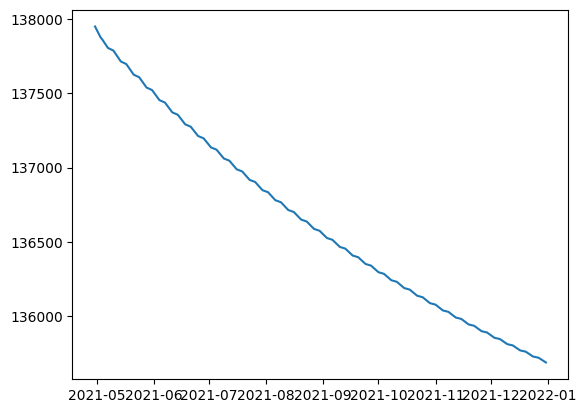

In [98]:
# visualize forecast
plt.plot(forecast)

In [34]:
# create monthly data
# df['month_year'] = df['Date'].dt.to_period('M')

In [124]:
daily.head()

,Date,Sales
0,2010-02-15,58706.0
1,2010-02-16,90843.0
2,2010-02-17,90227.0
3,2010-02-18,90822.0
4,2010-02-19,89663.0


In [135]:
forecast.reset_index(inplace=True)
forecast.head()

,index,Sales
0,2021-04-30,137948.630157
1,2021-05-03,137875.578674
2,2021-05-04,137860.229289
3,2021-05-05,137841.825680
4,2021-05-06,137823.223660


In [136]:
# forecast.drop("index", axis=1, inplace=True)
forecast.rename(columns={"index": "Date"}, inplace=True)
forecast.head()

,Date,Sales
0,2021-04-30,137948.630157
1,2021-05-03,137875.578674
2,2021-05-04,137860.229289
3,2021-05-05,137841.825680
4,2021-05-06,137823.223660


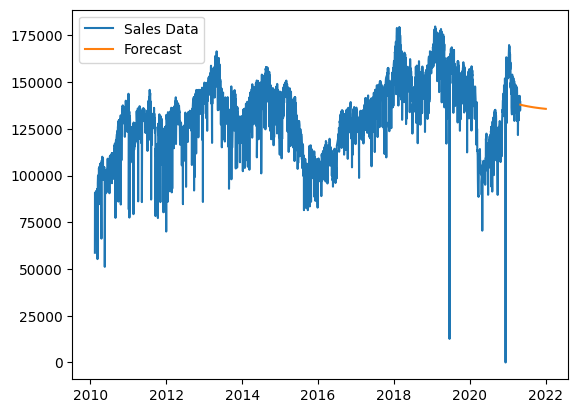

In [137]:
# visualize sales data and forecast
plt.plot(daily["Date"], daily["Sales"], label = "Sales Data")
plt.plot(forecast["Date"], forecast["Sales"], label = "Forecast")
plt.legend()
plt.show()

#  Predict When, If it Happens, a Total of 30 Million Goods is Sold in 2021


## Predict if Total Goods' Sales will Reach 30 Million in 2021

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93171 entries, 0 to 93170
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        93171 non-null  datetime64[ns]
 1   Maker       93171 non-null  object        
 2   Sales       93171 non-null  float64       
 3   Identifier  93171 non-null  object        
 4   Category    93171 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 3.6+ MB


In [76]:
# get data for the year 2021
year_2021_data = df[pd.DatetimeIndex(df['Date']).year == 2021]
year_2021_data.head()

,Date,Maker,Sales,Identifier,Category
90255,2021-01-04,Akaza,1035.0,ZBYVQNRPUP,Vacuum Cleaners
90256,2021-01-04,Akaza,3000.0,XVIOZZOUTN,Refrigerators
90257,2021-01-04,Akaza,6211.0,VUQUQMHODG,Washers & Dryers
90258,2021-01-04,Funami,14523.0,ZJPMAJIMIT,Water Pumps
90259,2021-01-04,Funami,1024.0,BIBIOOIHA,Refrigerators


In [77]:
len(year_2021_data)

2916

In [85]:
# get total sales amount from 2021 original data
sales_2021 = year_2021_data["Sales"].sum()
print("The total sales amount in 2021 from the original data is {:,.2f}".format(sales_2021))

The total sales amount in 2021 from the original data is 11,849,286.00


In [138]:
forecast.tail()

,Date,Sales
171,2021-12-27,135720.515530
172,2021-12-28,135712.466846
173,2021-12-29,135704.458186
174,2021-12-30,135696.489353
175,2021-12-31,135688.560148


In [101]:
# get total forecast sales amount for 2021
forecast_2021 = forecast["Sales"].sum()
print("The total forecast sales amount in 2021 is {:,.2f}".format(forecast_2021))

The total forecast sales amount in 2021 is 24,047,917.55


In [102]:
# get total sales amount for 2021
total_sales_2021 = sales_2021 + forecast_2021
print("The total sales amount in 2021 is {:,.2f}".format(total_sales_2021))

The total sales amount in 2021 is 35,897,203.55


Apparently the total sales in 2021 is forecast to reach above 30 million. Now we will check when it is predicted to occur.

## Predict When

In [112]:
# combine 2021 data into daily sales
year_2021_data = year_2021_data.drop("index", axis=1).groupby("Date").sum().reset_index()
year_2021_data.head()

,Date,Sales
0,2021-01-04,156022.0
1,2021-01-05,161050.0
2,2021-01-06,159184.0
3,2021-01-07,152695.0
4,2021-01-08,163192.0


In [116]:
# forecast.reset_index(inplace=True)
forecast.head()

,index,Sales
0,2021-04-30,137948.630157
1,2021-05-03,137875.578674
2,2021-05-04,137860.229289
3,2021-05-05,137841.825680
4,2021-05-06,137823.223660


In [141]:
# concatenate two dataframe
sales_2021_df = pd.concat([year_2021_data, forecast])
sales_2021_df.head()

,Date,Sales
0,2021-01-04,156022.0
1,2021-01-05,161050.0
2,2021-01-06,159184.0
3,2021-01-07,152695.0
4,2021-01-08,163192.0


In [142]:
sales_2021_df.tail()

,Date,Sales
171,2021-12-27,135720.515530
172,2021-12-28,135712.466846
173,2021-12-29,135704.458186
174,2021-12-30,135696.489353
175,2021-12-31,135688.560148


In [121]:
# ensure data are ordered based on dates
sales_2021_df.sort_values(["Date"], ignore_index=True, inplace=True)
sales_2021_df.head()

,Date,Sales
0,2021-01-04,156022.0
1,2021-01-05,161050.0
2,2021-01-06,159184.0
3,2021-01-07,152695.0
4,2021-01-08,163192.0


<Axes: xlabel='Date'>

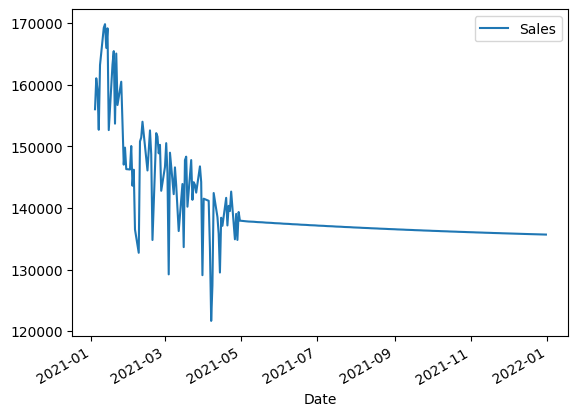

In [143]:
# visualize 2021 sales data and forecast
sales_2021_df.plot.line("Date", "Sales")

In [144]:
# add a column with cumulative sum
sales_2021_df["cumsum"] = sales_2021_df["Sales"].cumsum()
sales_2021_df.head()

,Date,Sales,cumsum
0,2021-01-04,156022.0,156022.0
1,2021-01-05,161050.0,317072.0
2,2021-01-06,159184.0,476256.0
3,2021-01-07,152695.0,628951.0
4,2021-01-08,163192.0,792143.0


In [145]:
more_than_30_mil = sales_2021_df[sales_2021_df["cumsum"] > 30000000]
more_than_30_mil.head()

,Date,Sales,cumsum
132,2021-11-02,136067.871318,3.005492e+07
133,2021-11-03,136058.095274,3.019098e+07
134,2021-11-04,136048.367846,3.032703e+07
135,2021-11-05,136038.688791,3.046307e+07
136,2021-11-08,136029.057869,3.059910e+07


According to the analysis, sales above 30 million of goods is predicted to occur on **Nov 2, 2021**.

# Suggest which Product(s) to be Cut

In [63]:
# group sales by product
prod_sales = df.groupby("Identifier").sum().reset_index()
prod_sales.head()

<ipython-input-63-5bd461225bba>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  prod_sales = df.groupby("Identifier").sum().reset_index()


,Identifier,Sales
0,AHSRVKIOLJ,1128970.0
1,AVXSMNNRDX,8672531.0
2,BIBIOOIHA,2801114.0
3,DUVTZNWNAB,405409.0
4,ECQPIOYXZO,17531891.0


In [64]:
len(prod_sales)

36

In [66]:
# order data based on number of sales
prod_sales.sort_values(["Sales"], ignore_index=True, ascending=False, inplace=True)
prod_sales.head()

,Identifier,Sales
0,HWTFIGIXOL,65211149.0
1,ZJPMAJIMIT,49415418.0
2,FUWHINIXUA,43789799.0
3,FVDHIZGQRC,30608445.0
4,VUQUQMHODG,18195886.0


<Axes: xlabel='Identifier'>

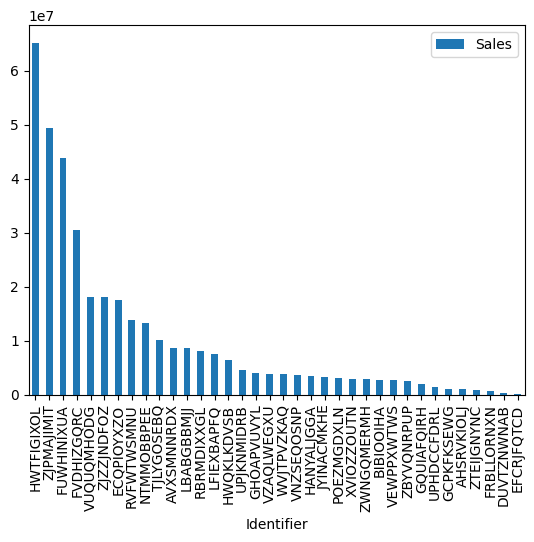

In [147]:
prod_sales.plot.bar("Identifier", "Sales")

In [67]:
# check product with the least sales
prod_sales.tail(1)

,Identifier,Sales
35,EFCRJFQTCD,86235.0


In [69]:
# get data only for this product
least_sold = df[df["Identifier"] == "EFCRJFQTCD"].sort_values("Date")
least_sold.head()

,Date,Maker,Sales,Identifier,Category
83396,2020-03-13,Nanase,140.0,EFCRJFQTCD,Televisions
83434,2020-03-16,Nanase,125.0,EFCRJFQTCD,Televisions
83468,2020-03-17,Nanase,125.0,EFCRJFQTCD,Televisions
83505,2020-03-18,Nanase,136.0,EFCRJFQTCD,Televisions
83542,2020-03-19,Nanase,133.0,EFCRJFQTCD,Televisions


<Axes: xlabel='Date'>

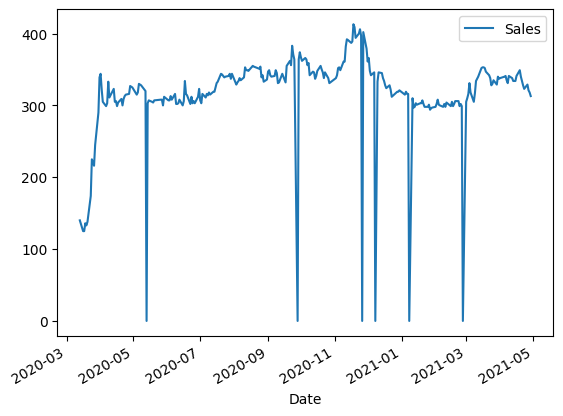

In [72]:
# plot sales for the least sold products
least_sold.plot.line("Date", "Sales")

Since this product has the least sales, I would recommend cutting this product: Identifier EFCRJFQTCD.

# 6. Recommendations: Ways to Improve Data Collection and How to Collect Data to Accommodate Future Data Analysis

Some ways to improve data collection:
- Consider using a relational database management system for storing data
- Record categories in one column
- Add product name in the data